In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hcp_utils as hcp
import nilearn as nl
import gc
import traceback
import logging
import pickle
import warnings
import joblib
from joblib import Parallel, delayed
from joblib import parallel_backend
from multiprocessing import Process, Manager
from joblib import Memory
warnings.filterwarnings(action='ignore')

/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
header = hcp.mmp.labels
header_cont = header
header_cont[0] = 'Subject_key'
header_list = list(header.values())[1:]


In [21]:
# output_path = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/nilearn_glm/functional_tables/'
output_path = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/'

In [10]:
## set variable for each dir task = WM
path = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/surf_WM_std/'
task_label = "verbal" # Spatial
space_label = "space-fsLR"
derivatives_folder = "derivatives/fmriprep"
direction = ['1', '2', 'mean']
stat = ['z','effect']
contrasts_ids= [    
    'oneback',
    'twoback',
    'twoback-oneback']
ses = '01'

In [5]:
items = os.listdir(path)
# Filter out non-folders (directories)
folders = [item for item in items if os.path.isdir(os.path.join(path, item))]


In [6]:
len(folders)

79

In [7]:
def load_tables(sub, contr, all_effect, all_zscore):
    try:
        # global all_effect
        # global all_zscore
        eff = path + '%s/%s_task-%s_contrast-%s_effect_parcelations.tsv' %(sub, sub, task_label, contr)
        z = path + '%s/%s_task-%s_contrast-%s_z_parcelations.tsv' %(sub, sub, task_label, contr)
        if os.path.isfile(eff):
            eff_data = pd.read_csv(eff, sep='\t', skiprows=[2])
            eff_data = eff_data.drop(eff_data.columns[0], axis=1)
            # eff_data.insert(0, 'Subject_ID', sub[4:])
            z_data = pd.read_csv(z, sep='\t', skiprows=[2])
            z_data = z_data.drop(z_data.columns[0], axis=1)
            # z_data.insert(0, 'Subject_ID', sub[4:])
            all_effect[sub] = eff_data
            all_zscore[sub] = z_data
            # all_effect = pd.concat([all_effect, eff_data], axis=0, ignore_index=True)
            # all_zscore = pd.concat([all_zscore,z_data], axis=0, ignore_index=True)
            gc.collect()
    except Exception as e:
        #error.append(sub_label)
        logging.error(traceback.format_exc())

In [8]:
def extract_tables(contr, all_cont_ef, all_cont_z):
    try:
        manager = Manager()
        all_effect = manager.dict()
        all_zscore = manager.dict()
        #pd.DataFrame()
        #pd.DataFrame()
        Parallel(n_jobs=40)(delayed(load_tables)(sub, contr, all_effect, all_zscore) for iter, sub in enumerate(folders))
        all_ef = dict(all_effect)
        all_z = dict(all_zscore)
        all_ef_df = pd.concat(list(all_ef.values()), axis=0, keys=all_ef.keys())
        all_z_df = pd.concat(list(all_z.values()), axis=0, keys=all_z.keys())
        all_ef_df.reset_index(level=1, inplace=True)
        all_z_df.reset_index(level=1, inplace=True)

        # all_ef_df.columns = ['Subject_key'] + list(all_ef_df.columns[1:])
        # all_ef_df.columns = header_cont
        all_ef_df.reset_index(inplace=True)
        all_z_df.reset_index(inplace=True)

        all_ef_df = all_ef_df.drop(all_ef_df.columns[1], axis=1)
        all_z_df = all_z_df.drop(all_z_df.columns[1], axis=1)
        all_ef_df.columns = ['Subject_key'] + list(all_ef_df.columns[1:])
        all_z_df.columns = ['Subject_key'] + list(all_z_df.columns[1:])
        all_ef_df = all_ef_df.set_index('Subject_key').reindex(folders)
        all_z_df = all_z_df.set_index('Subject_key').reindex(folders)
        all_ef_df.to_csv(output_path + 'task-%s_contrast-%s_stat-effect_Glasser.csv' %(task_label, contr), index=True)
        all_z_df.to_csv(output_path + 'task-%s_contrast-%s_stat-z_Glasser.csv' %(task_label, contr), index=True)
        # all_ef_df.set_index('Subject_key').reindex(folders)
        wide_columns = [f"{col}_{contr}" for col in all_ef_df.columns]
        all_ef_df.columns = wide_columns
        all_z_df.columns = wide_columns
        all_cont_ef[contr] = all_ef_df
        all_cont_z[contr] = all_z_df
        gc.collect()
        
    except Exception as e:
        #error.append(sub_label)
        logging.error(traceback.format_exc())


In [11]:
## run parallel

plt.ioff
fmanager = Manager()
all_cont_ef = fmanager.dict()
all_cont_z = fmanager.dict()
Parallel(n_jobs=30)(delayed(extract_tables)(contrast, all_cont_ef, all_cont_z) for iter, contrast in enumerate(contrasts_ids))
all_ef = dict(all_cont_ef)
all_z = dict(all_cont_z)
all_ef_df = pd.concat(all_ef.values(), axis=1)
all_z_df = pd.concat(all_z.values(), axis=1)

all_ef_df.to_csv(output_path + 'task-%s_contrast-All_stat-effect_Glasser.csv' %(task_label), index=True)
all_z_df.to_csv(output_path + 'task-%s_contrast-All_stat-z_Glasser.csv' %(task_label), index=True)

### task connectivity

In [5]:
def load_tc(sub, all_cen, all_uncen, measure):
    try:
        log = con_path + '%s/%s_ses-T1_task-%s_scrubbing_log.tsv' %(sub, sub, task_label)
        cen = con_path + '%s/%s_ses-T1_task-%s_space-fsLR_atlas-Glasser_desc-censored_measure-%s_conmat.tsv' %(sub, sub, task_label, measure)
        uncen = con_path + '%s/%s_ses-T1_task-%s_space-fsLR_atlas-Glasser_desc-uncensored_measure-%s_conmat.tsv' %(sub, sub, task_label, measure)
        if os.path.isfile(log) and os.path.isfile(uncen):
            log_data = pd.read_csv(log, sep='\t')
            if log_data['del vols'][0] < log_data['N of vols needed'][0]:
                # print('valid')
                cen_data = pd.read_csv(cen, sep='\t')
                uncen_data = pd.read_csv(uncen, sep='\t')
                cen_data = cen_data.drop(cen_data.columns[0], axis=1)
                uncen_data = uncen_data.drop(uncen_data.columns[0], axis=1)
                cen_data.index = header_list
                uncen_data.index = header_list
                # filtered_cen = pd.DataFrame(nl.signal.clean(cen_data.values, detrend=False, high_pass=0.008, t_r=0.8), columns=cen_data.columns)
                # filtered_uncen = pd.DataFrame(nl.signal.clean(uncen_data.values, detrend=False, high_pass=0.008, t_r=0.8), columns=uncen_data.columns)
                # zconn_mat = np.arctanh(cen_data)
                # flatten:
                ### Transform matrix to string for the subject
                cen_f = cen_data.where(np.triu(np.ones(cen_data.shape), k=1).astype(bool)).stack().reset_index()
                indx = [i+'_&_'+j for i,j in zip(cen_f['level_0'], cen_f['level_1'])]
                flat_cen = pd.Series(np.array(cen_f[0]),index=indx).to_frame().T

                uncen_f = uncen_data.where(np.triu(np.ones(uncen_data.shape), k=1).astype(bool)).stack().reset_index()
                indx = [i+'_&_'+j for i,j in zip(uncen_f['level_0'], uncen_f['level_1'])]
                flat_uncen = pd.Series(np.array(uncen_f[0]),index=indx).to_frame().T
                
                flat_cen['Subject_key'] = sub[4:] 
                flat_uncen['Subject_key'] = sub[4:] 
                flat_cen.insert(0, 'Subject_key', flat_cen.pop('Subject_key')) 
                flat_uncen.insert(0, 'Subject_key', flat_uncen.pop('Subject_key')) 
                all_cen[sub] = flat_cen
                all_uncen[sub] = flat_uncen
        gc.collect()
    except Exception as e:
        logging.error(traceback.format_exc())

In [8]:
# get subs with valid mean :
measures = ['pearsoncorrelation']#'tangent','partialcorrelation'pearsoncorrelation
tasks = ['verbal'] ## Spatial
tasks_folder = ['WM'] #
for i, task_label in enumerate(tasks): 
    for measure in measures:
        con_path = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/tconnectivity_%s/scrubbed-despiked/' %tasks_folder[i]
        con_items = os.listdir(con_path)
        print(tasks_folder[i])
        con_folders = [item for item in con_items if os.path.isdir(os.path.join(con_path, item))]
        tcmanager = Manager()
        all_cen = tcmanager.dict()
        all_uncen = tcmanager.dict()
        Parallel(n_jobs=10)(delayed(load_tc)(sub, all_cen, all_uncen, measure) for iter, sub in enumerate(con_folders))
        all_c = dict(all_cen)
        all_u = dict(all_uncen)
        all_cend = pd.concat(all_c.values(), axis=0, ignore_index=True)
        all_uncend = pd.concat(all_u.values(), axis=0, ignore_index=True)
        all_cend.to_csv(output_path + 'task-%s_stat-%s_desc-CensoredFilteredFlat_Connectivity.csv' %(task_label, measure), index=False)
        all_uncend.to_csv(output_path + 'task-%s_stat-%s_desc-UncensoredFilteredFlat_Connectivity.csv' %(task_label, measure), index=False)

        with open(output_path + 'task-%s_stat-%s_desc-CensoredFilteredFlat_Connectivity'%(task_label, measure), 'wb') as file:
            pickle.dump(all_cend, file)
        with open(output_path + 'task-%s_stat-%s_desc-UncensoredFilteredFlat_Connectivity' %(task_label, measure), 'wb') as file:
            pickle.dump(all_uncend, file)
        gc.collect()
    

Sel


In [11]:
# get subs with valid mean GFC:
def load_tc(sub, all_cen, all_uncen, measure):
    try:
        # log = con_path + '%s/%s_task-%s_scrubbing_log.tsv' %(sub, sub, task_label)
        # cen = con_path + '%s/%s_task-%s_run-all_space-fsLR_atlas-Glasser_desc-censored_measure-%s_conmat.tsv' %(sub, sub, task_label, measure)
        uncen = con_path + '%s/%s_space-fsLR_atlas-Glasser_desc-task_measure-%s_conmat.tsv' %(sub, sub, measure)
        if os.path.isfile(uncen):
            # log_data = pd.read_csv(log, sep='\t')
            # if log_data['del vols'][2] < log_data['N of vols needed'][2]:
                # cen_data = pd.read_csv(cen, sep='\t')
            uncen_data = pd.read_csv(uncen, sep='\t')
            # cen_data = cen_data.drop(cen_data.columns[0], axis=1)
            uncen_data = uncen_data.drop(uncen_data.columns[0], axis=1)
            # cen_data.index = header_list
            uncen_data.index = header_list
            # filtered_cen = pd.DataFrame(nl.signal.clean(cen_data.values, detrend=False, high_pass=0.008, t_r=0.8), columns=cen_data.columns)
            # filtered_uncen = pd.DataFrame(nl.signal.clean(uncen_data.values, detrend=False, high_pass=0.008, t_r=0.8), columns=uncen_data.columns)
            # zconn_mat = np.arctanh(cen_data)
            # flatten:
            ### Transform matrix to string for the subject
            # cen_f = cen_data.where(np.triu(np.ones(cen_data.shape), k=1).astype(bool)).stack().reset_index()
            # indx = [i+'_&_'+j for i,j in zip(cen_f['level_0'], cen_f['level_1'])]
            # flat_cen = pd.Series(np.array(cen_f[0]),index=indx).to_frame().T

            uncen_f = uncen_data.where(np.triu(np.ones(uncen_data.shape), k=1).astype(bool)).stack().reset_index()
            indx = [i+'_&_'+j for i,j in zip(uncen_f['level_0'], uncen_f['level_1'])]
            flat_uncen = pd.Series(np.array(uncen_f[0]),index=indx).to_frame().T
            
            # flat_cen['Subject_key'] = sub[4:] 
            flat_uncen['Subject_key'] = sub[4:] 
            # flat_cen.insert(0, 'Subject_key', flat_cen.pop('Subject_key')) 
            flat_uncen.insert(0, 'Subject_key', flat_uncen.pop('Subject_key')) 
            # all_cen[sub] = flat_cen
            all_uncen[sub] = flat_uncen
        gc.collect()
    except Exception as e:
        logging.error(traceback.format_exc())

In [12]:
# get subs with valid mean GFC:
measures = ['pearsoncorrelation']
tasks = ['tfc'] # tfc
# tasks_folder = ['MID'] #'WM','SST', 'MID',
for i, task_label in enumerate(tasks): 
    for measure in measures:
        con_path = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/FC-valid/'
        con_items = os.listdir(con_path)
        # print(tasks_folder[i])
        con_folders = [item for item in con_items if os.path.isdir(os.path.join(con_path, item))]
        tcmanager = Manager()
        all_cen = tcmanager.dict()
        all_uncen = tcmanager.dict()
        Parallel(n_jobs=30)(delayed(load_tc)(sub, all_cen, all_uncen, measure) for iter, sub in enumerate(con_folders))
        # all_c = dict(all_cen)
        all_u = dict(all_uncen)
        # all_cend = pd.concat(all_c.values(), axis=0, ignore_index=True)
        all_uncend = pd.concat(all_u.values(), axis=0, ignore_index=True)
        # all_cend.to_csv(output_path + 'task-%s_stat-%s_desc-CensoredFilteredFlat_Connectivity.csv' %(task_label, measure), index=False)
        all_uncend.to_csv(output_path + 'task-%s_stat-%s_desc-UncensoredFilteredFlat_Connectivity.csv' %(task_label, measure), index=False)

        # with open(output_path + 'task-%s_stat-%s_desc-CensoredFilteredFlat_Connectivity'%(task_label, measure), 'wb') as file:
        #     pickle.dump(all_cend, file)
        with open(output_path + 'task-%s_stat-%s_desc-UncensoredFilteredFlat_Connectivity' %(task_label, measure), 'wb') as file:
            pickle.dump(all_uncend, file)
        gc.collect()
    

In [27]:
# target tables:
d1_iq = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/phenotype/ses-T1/wasi.tsv'
d2_iq = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/phenotype/wisc-iii.tsv'

d1_targ = pd.read_csv(d1_iq, sep='\t', index_col=0)[['WASI_VIQ','WASI_PIQ','WASI_FSIQ']]
d2_targ = pd.read_csv(d2_iq, sep='\t', index_col=0)[['WISC_VIQ','WISC_PIQ','WISC_FSIQ']]

# d1_targ.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog.csv')
# d2_targ.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog.csv')


In [49]:
#adhd groups:
demo = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/participants.tsv', sep='\t', index_col=0)
adhd1 =  demo[(demo['ADHD_diagnosis'].isin([1]))]
non1 =  demo[(demo['ADHD_diagnosis'].isin([0]))]
cog_table1 = demo.join(d1_targ)
# Find shared indices
shared_adhd1 = adhd1.index.intersection(d1_targ.index)
shared_non1 = non1.index.intersection(d1_targ.index)
# Filter both DataFrames to include only the shared indices
adhd1_cog = d1_targ.loc[shared_adhd1]
non1_cog = d1_targ.loc[shared_non1]

adhd1_cog.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog_adhd1.csv')
non1_cog.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog_non1.csv')

In [85]:
#adhd groups:
demo2 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/participants.tsv', sep='\t', index_col=0)
adhd2 =  demo2[(demo2['adhd'].isin([1]))]
non2 =  demo2[(demo2['adhd'].isin([0]))]
# Find shared indices
shared_adhd2 = adhd2.index.intersection(d2_targ.index)
shared_non2 = non2.index.intersection(d2_targ.index)
# Filter both DataFrames to include only the shared indices
adhd2_cog = d2_targ.loc[shared_adhd2]
non2_cog = d2_targ.loc[shared_non2]
adhd2_cog.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog_adhd2.csv')
non2_cog.to_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog_non2.csv')
print(adhd2_cog.shape, non2_cog.shape)

(12, 3) (26, 3)


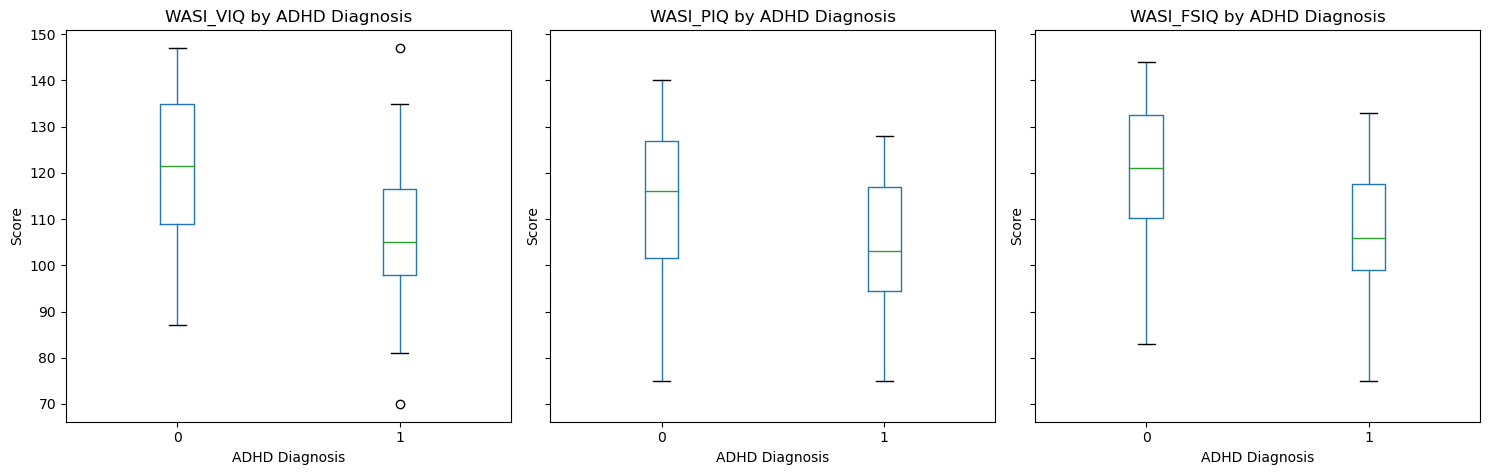

In [84]:
cog_table1 = demo.join(d1_targ)
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, score in enumerate(['WASI_VIQ', 'WASI_PIQ', 'WASI_FSIQ']):
    cog_table1.boxplot(column=score, by='ADHD_diagnosis', ax=ax[i])
    ax[i].set_title(f'{score} by ADHD Diagnosis')
    ax[i].set_xlabel('ADHD Diagnosis')
    ax[i].set_ylabel('Score')
    ax[i].grid(False)
plt.suptitle('')
plt.tight_layout()
plt.show()

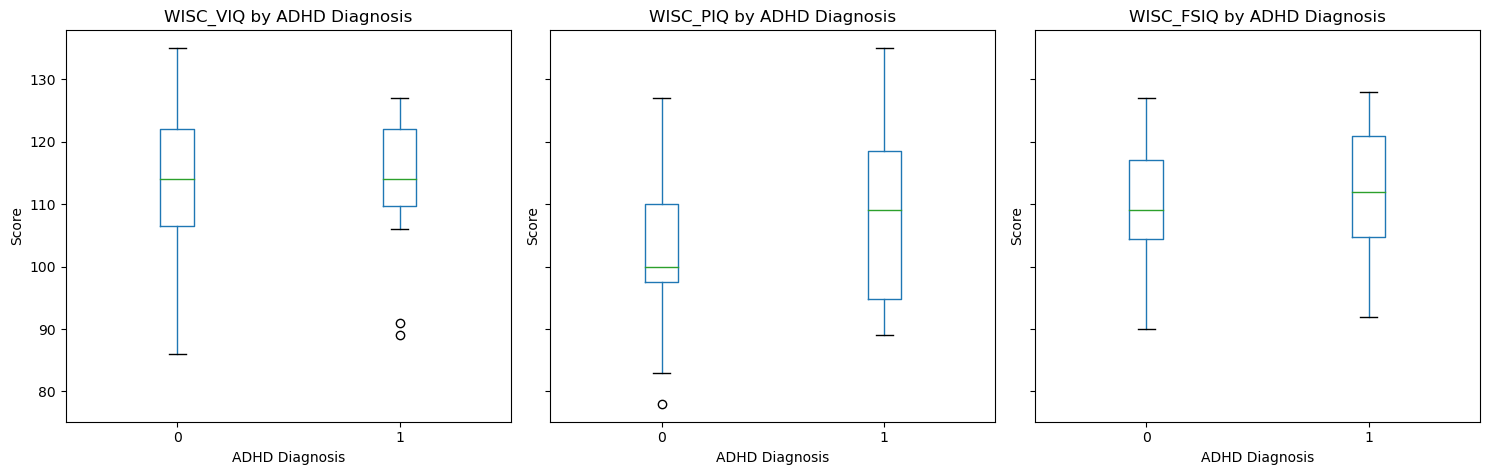

In [83]:
cog_table2 = demo2.join(d2_targ)
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, score in enumerate(['WISC_VIQ', 'WISC_PIQ', 'WISC_FSIQ']):
    cog_table2.boxplot(column=score, by='adhd', ax=ax[i])
    ax[i].set_title(f'{score} by ADHD Diagnosis')
    ax[i].set_xlabel('ADHD Diagnosis')
    ax[i].set_ylabel('Score')
    ax[i].grid(False)
plt.suptitle('')
plt.tight_layout()
plt.show()

In [79]:
from scipy.stats import ttest_ind
group_0 = cog_table1[cog_table1['ADHD_diagnosis'] == 0]
group_1 = cog_table1[cog_table1['ADHD_diagnosis'] == 1]

# Perform t-tests for each cognitive score
for score in ['WASI_VIQ', 'WASI_PIQ', 'WASI_FSIQ']:
    
    t_stat, p_value = ttest_ind(group_0[score].dropna(), group_1[score].dropna())
    print(f"T-test for {score}: t-statistic = {t_stat}, p-value = {p_value}", )

T-test for WASI_VIQ: t-statistic = 3.923889964323009, p-value = 0.00018806505583572285
T-test for WASI_PIQ: t-statistic = 3.1884488311720305, p-value = 0.0020778165541126604
T-test for WASI_FSIQ: t-statistic = 3.9946400909330237, p-value = 0.00014707611652319886


In [80]:
from scipy.stats import ttest_ind
group_0 = cog_table2[cog_table2['adhd'] == 0]
group_1 = cog_table2[cog_table2['adhd'] == 1]

# Perform t-tests for each cognitive score
for score in ['WISC_VIQ', 'WISC_PIQ', 'WISC_FSIQ']:
    t_stat, p_value = ttest_ind(group_0[score].dropna(), group_1[score].dropna())
    print(f"T-test for {score}: t-statistic = {t_stat}, p-value = {p_value}")

T-test for WISC_VIQ: t-statistic = 0.19724845457259013, p-value = 0.8452280330754859
T-test for WISC_PIQ: t-statistic = -1.0420696003566656, p-value = 0.3073524205127033
T-test for WISC_FSIQ: t-statistic = -0.41657039210574165, p-value = 0.680547628870054


In [12]:
FC = {}
# FC.update({'gfc': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/task-gfc_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})
FC.update({'tfc': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/task-tfc_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})

conn = {}
conn.update({'spatial': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/task-spatial_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})
conn.update({'verbal': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/task-verbal_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})

for key, item in conn.items():
    print(item.index )#item.index,item.isna().sum()
    item.index = item.index.astype(str)

for key, item in FC.items():
    print(item.index )#item.index,item.isna().sum()
    item.index = item.index.astype(str)

Index([68, 30, 66, 56, 60,  4, 48, 16, 67, 38, 40, 31, 73, 79, 12, 27, 20,  3,
       36, 35, 26, 78, 17, 41,  2, 52, 74, 77, 37, 19,  8, 71,  1, 58, 33, 13,
       61, 49, 53, 46, 39, 22, 10, 72, 28, 15, 51, 54, 29, 47, 14, 76,  6, 44,
        7, 18, 23,  9, 21, 69],
      dtype='int64', name='Subject_key')
Index([68, 11, 30, 64, 66, 56, 60, 65, 42, 16, 59, 48, 67,  4, 26, 38, 40, 73,
       79, 17,  2, 31, 74,  3, 27, 52, 12, 41, 20, 77, 55, 45, 34, 19, 35, 53,
       36, 46, 71, 37,  5, 51, 33, 58, 10, 32, 63, 39, 61, 49, 28, 54, 72, 76,
       29, 24, 15,  6, 47, 44,  7, 18, 23, 50,  9, 21, 69],
      dtype='int64', name='Subject_key')
Index([68, 56, 30, 66, 60, 16, 48, 59,  4, 67, 38, 40, 73, 26, 17, 79, 31,  2,
        3, 77, 41, 74, 52, 20, 36, 53, 46, 58, 22, 13, 35, 71, 63, 33, 32, 28,
       19, 27, 37, 12, 72, 15, 39, 61, 49, 10, 51, 29, 54, 76, 47,  6, 44, 21,
       18, 23,  7,  9, 69],
      dtype='int64', name='Subject_key')


In [24]:
FC = {}
# FC.update({'gfc': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/task-gfc_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})
FC.update({'tfc': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/nilearn_glm/functional_tables/task-tfc_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})

conn = {}
conn.update({'Inh': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/nilearn_glm/functional_tables/task-Inh_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})
conn.update({'Sel': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/nilearn_glm/functional_tables/task-Sel_stat-pearsoncorrelation_desc-UncensoredFilteredFlat_Connectivity.csv', index_col=0)})

for key, item in conn.items():
    print(item.index )#item.index,item.isna().sum()
    item.index = item.index.astype(str)

for key, item in FC.items():
    print(item.index )#item.index,item.isna().sum()
    item.index = item.index.astype(str)

Index([245, 246, 259, 234, 254, 214, 226, 238, 218, 219, 248, 253, 240, 222,
       213, 260, 223, 236, 224, 251, 230, 235, 232, 242, 221, 225, 241, 228,
       237, 256],
      dtype='int64', name='Subject_key')
Index([246, 234, 245, 259, 254, 238, 214, 219, 218, 268, 226, 248, 253, 220,
       222, 236, 240, 223, 260, 213, 224, 242, 251, 225, 230, 231, 235, 221,
       256, 232, 228, 262, 241, 237],
      dtype='int64', name='Subject_key')
Index([246, 245, 254, 259, 234, 219, 214, 218, 222, 248, 213, 238, 236, 240,
       226, 223, 260, 232, 242, 221, 241, 256, 237, 253, 230, 228, 225, 224,
       251, 235],
      dtype='int64', name='Subject_key')


In [13]:
joblib.dump(FC, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/nesi_input_all/gtfc_dict.joblib')

joblib.dump(conn, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/nesi_input_all/conn_dict.joblib', compress=2)

['/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/nesi_input_all/conn_dict.joblib']

In [25]:
joblib.dump(FC, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/gtfc_dict.joblib')

joblib.dump(conn, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/conn_dict.joblib', compress=2)

['/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/conn_dict.joblib']

In [47]:
### convert long format all contrasts tables (before std) to wide individual contrasts and add them to features dictionary
file_names = ['task-verbal_contrast-All_stat-effect_Glasser.csv','task-spatial_contrast-All_stat-effect_Glasser.csv']
task_dir = '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/nilearn_glm/functional_tables/'
cntr_dict = {}

for file in file_names:
    contall = pd.read_csv(task_dir + file, index_col=0, low_memory=False)
    contall.index = contall.index.str.replace('sub-', '')
    contrast_types = contall.columns.str.split('_').str[-1].unique()
    # print(fold, file, contrast_types)
    # tables = {}
    for contrast_type in contrast_types:
        columns = [col for col in contall.columns if col.endswith(f'_{contrast_type}')]
        table = contall[columns].rename(columns=lambda x: x.replace('_'+contrast_type, ""))
        # print(fold, contrast_type)
        cntr_name = 'cntr_' + contrast_type + '_' + file.split('_')[0]
        # table.to_csv(task_dir + 'contrasts/' + cntr_name + '.csv')
        cntr_dict.update({
        cntr_name: table,
        })
        print(table.shape)
joblib.dump(cntr_dict, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/nesi_input_all/cntr_dict.joblib')

(79, 379)
(79, 379)
(79, 379)
(79, 379)
(79, 379)
(79, 379)


['/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/nesi_input_all/cntr_dict.joblib']

In [39]:
smri = {}
smri.update({'surf': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cortical_area.csv', index_col=0)})
smri.update({'cort': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cortical_thickness.csv', index_col=0)})
smri.update({'subc': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/subcortical_volume.csv', index_col=0).drop(columns=[])})
smri.update({'VolBrain': pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/total_brain_volume.csv', index_col=0)})

for key, item in smri.items():
    item.index = item.index.str.replace('sub-', '')

smri['subc'].isna().sum()


ACCUMBENS_LEFT                0
ACCUMBENS_RIGHT               0
AMYGDALA_LEFT                 0
AMYGDALA_RIGHT                0
BRAIN_STEM                    0
CAUDATE_LEFT                  0
CAUDATE_RIGHT                 0
CEREBELLUM_LEFT               0
CEREBELLUM_RIGHT              0
DIENCEPHALON_VENTRAL_LEFT     0
DIENCEPHALON_VENTRAL_RIGHT    0
HIPPOCAMPUS_LEFT              0
HIPPOCAMPUS_RIGHT             0
PALLIDUM_LEFT                 0
PALLIDUM_RIGHT                0
PUTAMEN_LEFT                  0
PUTAMEN_RIGHT                 0
THALAMUS_LEFT                 0
THALAMUS_RIGHT                0
dtype: int64

In [40]:
joblib.dump(smri, '/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/smri_dict.joblib')

['/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/smri_dict.joblib']

In [41]:
targs = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog.csv', index_col=0)
targs.index = targs.index.str.replace('sub-', '')
test_index = np.array(targs.index) 
x_te = smri['subc'].reindex(index = test_index).dropna()

In [42]:
x_te

,ACCUMBENS_LEFT,ACCUMBENS_RIGHT,AMYGDALA_LEFT,AMYGDALA_RIGHT,BRAIN_STEM,CAUDATE_LEFT,CAUDATE_RIGHT,CEREBELLUM_LEFT,CEREBELLUM_RIGHT,DIENCEPHALON_VENTRAL_LEFT,DIENCEPHALON_VENTRAL_RIGHT,HIPPOCAMPUS_LEFT,HIPPOCAMPUS_RIGHT,PALLIDUM_LEFT,PALLIDUM_RIGHT,PUTAMEN_LEFT,PUTAMEN_RIGHT,THALAMUS_LEFT,THALAMUS_RIGHT
213,447.0,370.3,1213.9,1507.7,21438.3,3532.5,3801.5,47400.5,52907.9,4486.4,4593.4,4110.0,4237.9,1998.5,2071.2,4894.6,4926.9,8832.9,7983.1
214,756.3,720.6,1641.9,1840.7,19435.6,4307.3,4276.4,53104.9,57093.2,4429.0,5033.1,4795.5,5163.2,2323.3,2332.5,5782.2,5941.7,8189.9,8149.2
218,380.0,512.7,1713.6,1626.7,21079.0,3991.1,3752.1,62115.9,64344.5,4671.5,4367.5,4655.6,4445.8,2002.7,2099.9,4842.2,5053.8,7941.2,7748.8
219,642.4,698.3,1722.2,1976.7,20443.9,4035.6,4153.4,55914.2,55758.5,4338.0,4088.8,3822.1,3899.8,2180.8,2576.0,5668.9,5133.5,8535.7,8766.2
220,257.0,291.3,1232.0,1345.9,15003.3,3025.2,3105.3,46551.7,46801.0,3499.4,3197.2,3810.0,3528.1,1573.7,1760.8,4304.8,4032.1,6161.4,5585.3
221,450.0,519.5,1723.7,2022.7,21135.5,4234.6,4757.5,57530.2,58361.1,4741.5,4293.3,4826.0,5127.4,2104.5,2498.6,5273.6,5529.6,9160.1,7987.2
222,548.2,543.9,1359.5,1540.5,21559.7,3384.5,3405.3,59937.8,58803.6,4030.3,3967.3,4045.8,4186.9,1915.0,1928.5,4311.9,4786.4,7887.4,7456.9
223,455.1,513.4,1474.5,1482.3,21064.3,3821.0,3647.4,46825.0,49076.9,4166.4,4044.2,4040.8,4075.4,1916.0,1876.1,4282.1,4144.4,7925.9,7841.6
224,499.8,613.2,1824.8,1803.4,21551.8,3189.0,3525.6,64629.5,65699.2,4876.8,4535.5,4448.4,4478.1,2297.9,2226.2,5675.1,5723.1,8649.5,7416.0
225,422.0,607.4,1402.2,1535.1,16757.5,4091.8,3881.8,48116.3,49876.8,3630.0,3584.4,3710.7,3707.1,1766.8,1837.2,4663.6,5198.3,7592.3,6902.0


In [43]:
smri['subc']

,ACCUMBENS_LEFT,ACCUMBENS_RIGHT,AMYGDALA_LEFT,AMYGDALA_RIGHT,BRAIN_STEM,CAUDATE_LEFT,CAUDATE_RIGHT,CEREBELLUM_LEFT,CEREBELLUM_RIGHT,DIENCEPHALON_VENTRAL_LEFT,DIENCEPHALON_VENTRAL_RIGHT,HIPPOCAMPUS_LEFT,HIPPOCAMPUS_RIGHT,PALLIDUM_LEFT,PALLIDUM_RIGHT,PUTAMEN_LEFT,PUTAMEN_RIGHT,THALAMUS_LEFT,THALAMUS_RIGHT
213,447.0,370.3,1213.9,1507.7,21438.3,3532.5,3801.5,47400.5,52907.9,4486.4,4593.4,4110.0,4237.9,1998.5,2071.2,4894.6,4926.9,8832.9,7983.1
214,756.3,720.6,1641.9,1840.7,19435.6,4307.3,4276.4,53104.9,57093.2,4429.0,5033.1,4795.5,5163.2,2323.3,2332.5,5782.2,5941.7,8189.9,8149.2
218,380.0,512.7,1713.6,1626.7,21079.0,3991.1,3752.1,62115.9,64344.5,4671.5,4367.5,4655.6,4445.8,2002.7,2099.9,4842.2,5053.8,7941.2,7748.8
219,642.4,698.3,1722.2,1976.7,20443.9,4035.6,4153.4,55914.2,55758.5,4338.0,4088.8,3822.1,3899.8,2180.8,2576.0,5668.9,5133.5,8535.7,8766.2
220,257.0,291.3,1232.0,1345.9,15003.3,3025.2,3105.3,46551.7,46801.0,3499.4,3197.2,3810.0,3528.1,1573.7,1760.8,4304.8,4032.1,6161.4,5585.3
221,450.0,519.5,1723.7,2022.7,21135.5,4234.6,4757.5,57530.2,58361.1,4741.5,4293.3,4826.0,5127.4,2104.5,2498.6,5273.6,5529.6,9160.1,7987.2
222,548.2,543.9,1359.5,1540.5,21559.7,3384.5,3405.3,59937.8,58803.6,4030.3,3967.3,4045.8,4186.9,1915.0,1928.5,4311.9,4786.4,7887.4,7456.9
223,455.1,513.4,1474.5,1482.3,21064.3,3821.0,3647.4,46825.0,49076.9,4166.4,4044.2,4040.8,4075.4,1916.0,1876.1,4282.1,4144.4,7925.9,7841.6
224,499.8,613.2,1824.8,1803.4,21551.8,3189.0,3525.6,64629.5,65699.2,4876.8,4535.5,4448.4,4478.1,2297.9,2226.2,5675.1,5723.1,8649.5,7416.0
225,422.0,607.4,1402.2,1535.1,16757.5,4091.8,3881.8,48116.3,49876.8,3630.0,3584.4,3710.7,3707.1,1766.8,1837.2,4663.6,5198.3,7592.3,6902.0


In [22]:
smri = joblib.load('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/nesi_input_all/smri_dict.joblib')

In [23]:
smri['subc']

,ACCUMBENS_LEFT,ACCUMBENS_RIGHT,AMYGDALA_LEFT,AMYGDALA_RIGHT,BRAIN_STEM,CAUDATE_LEFT,CAUDATE_RIGHT,CEREBELLUM_LEFT,CEREBELLUM_RIGHT,DIENCEPHALON_VENTRAL_LEFT,DIENCEPHALON_VENTRAL_RIGHT,HIPPOCAMPUS_LEFT,HIPPOCAMPUS_RIGHT,PALLIDUM_LEFT,PALLIDUM_RIGHT,PUTAMEN_LEFT,PUTAMEN_RIGHT,THALAMUS_LEFT,THALAMUS_RIGHT
213,447.0,370.3,1213.9,1507.7,21438.3,3532.5,3801.5,47400.5,52907.9,4486.4,4593.4,4110.0,4237.9,1998.5,2071.2,4894.6,4926.9,8832.9,7983.1
214,756.3,720.6,1641.9,1840.7,19435.6,4307.3,4276.4,53104.9,57093.2,4429.0,5033.1,4795.5,5163.2,2323.3,2332.5,5782.2,5941.7,8189.9,8149.2
218,380.0,512.7,1713.6,1626.7,21079.0,3991.1,3752.1,62115.9,64344.5,4671.5,4367.5,4655.6,4445.8,2002.7,2099.9,4842.2,5053.8,7941.2,7748.8
219,642.4,698.3,1722.2,1976.7,20443.9,4035.6,4153.4,55914.2,55758.5,4338.0,4088.8,3822.1,3899.8,2180.8,2576.0,5668.9,5133.5,8535.7,8766.2
220,257.0,291.3,1232.0,1345.9,15003.3,3025.2,3105.3,46551.7,46801.0,3499.4,3197.2,3810.0,3528.1,1573.7,1760.8,4304.8,4032.1,6161.4,5585.3
221,450.0,519.5,1723.7,2022.7,21135.5,4234.6,4757.5,57530.2,58361.1,4741.5,4293.3,4826.0,5127.4,2104.5,2498.6,5273.6,5529.6,9160.1,7987.2
222,548.2,543.9,1359.5,1540.5,21559.7,3384.5,3405.3,59937.8,58803.6,4030.3,3967.3,4045.8,4186.9,1915.0,1928.5,4311.9,4786.4,7887.4,7456.9
223,455.1,513.4,1474.5,1482.3,21064.3,3821.0,3647.4,46825.0,49076.9,4166.4,4044.2,4040.8,4075.4,1916.0,1876.1,4282.1,4144.4,7925.9,7841.6
224,499.8,613.2,1824.8,1803.4,21551.8,3189.0,3525.6,64629.5,65699.2,4876.8,4535.5,4448.4,4478.1,2297.9,2226.2,5675.1,5723.1,8649.5,7416.0
225,422.0,607.4,1402.2,1535.1,16757.5,4091.8,3881.8,48116.3,49876.8,3630.0,3584.4,3710.7,3707.1,1766.8,1837.2,4663.6,5198.3,7592.3,6902.0
